In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities_v3 import *
from shutil import copyfile

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [14]:
def repeat(arr, count):
    z_sig = []
    for i in range(count):
        z_sig.extend(arr)
    return z_sig

def mock_injection_noise(alpha_scale,lambda_val,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF"):
    stroke=-202
    frequency=3
    axis="z"
    yuk_or_grav="yuk"
    alpha=1
    bead_size=7.6
    signal_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)
    
    # shift phase of signal according to TF
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    # convert to bits, this works only for one second chunk!
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    TF_phases = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]    
    if(phase_shift=="TF"):TF_phase_shift = TF_phases
    elif(phase_shift=="Flip"):TF_phase_shift = [-1*element for element in TF_phases] # this flips
    elif(phase_shift=="Random_TF"):TF_phase_shift = [1*np.random.normal(element,element/20) for element in TF_phases]
    elif(phase_shift=="Random"):TF_phase_shift =  np.random.uniform(-np.pi,np.pi,len(TF_phases))
    else:TF_phase_shift = len(TF_phases)*[0]
    print(TF_phase_shift)
    harmonics = np.arange(3,len(TF_phases)*3+3,3)

    #print(len(TF_phase_shift))
    # 6 charges new
    amplitude_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]

    fft_sim = np.fft.rfft(signal_sim[1]) 
    new_fft_sim = fft_sim.copy()
    new_fft_shift_only = fft_sim.copy()
   # new_fft_sim[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim[0]) # not necessary?
    for harmonic in harmonics:
        new_fft_shift_only[harmonic] = np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))
        new_fft_sim[harmonic] = 1/amplitude_scale[harmonic//3-1] * np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))

    signal_sim_shift=np.fft.irfft(new_fft_shift_only) 
    signal_sim_shift_scale =np.fft.irfft(new_fft_sim) 
    
    
    # extend to 10s
    z_sig = repeat(signal_sim_shift_scale,10)
    # scale to desired alpha
    z_trans_amp = np.multiply(z_sig,alpha_scale)
    
    return z_trans_amp,TF_phase_shift,amplitude_scale

In [3]:
def file_creator(in_file_paths,out_dir,direction,run_no,max_file=1000):
    i=0
    out_dirs=  out_dir+"/%d/" %run_no
    try: os.makedirs(out_dirs)
    except: print("Did not create %s. It may exist or you do not have perimissions." %out_dir)    

    for file_path in in_file_paths:
        #print(file_path)
        i+=1
        if(i<(max_file+1)):
            #if (i % 10==0):print("%f percent" %(i/max_file*100))
            with h5py.File(file_path, 'r') as f_in:
                quad_data_in = np.array(f_in['quad_data'])
                data_in = quad_data_in.reshape(-1,12).T[9]
                #plt.plot(np.array(data_in))
                if(direction=="push"): z_sn = np.subtract(np.array(data_in),np.array(z_trans_amp))
                elif(direction=="pull"): z_sn = np.add(np.array(data_in),np.array(z_trans_amp))
                else: print("Force has to go either way")
                quad_data_in.reshape(-1,12).T[9] = z_sn
                f_in.close()
                #plt.plot(np.array(z_sn),color="black")
            out_path = out_dirs + "Noise_batch_%d.h5" %(i-1)
            copyfile(src=file_path, dst=out_path)
            with h5py.File(out_path, 'r+') as f_out:
                del f_out['quad_data']
                f_out.create_dataset("quad_data", quad_data_in.shape,data=quad_data_in)
                f_out.close()
    return print("Done")

In [4]:
def file_creator_rounding_uniform_random_noise(in_file_paths,out_dir,direction,run_no,max_file=1000):
    i=0
    out_dirs=  out_dir+"/%d/" %run_no
    try: os.makedirs(out_dirs)
    except: print("Did not create %s. It may exist or you do not have perimissions." %out_dir)    

    for file_path in in_file_paths:
        #print(file_path)
        i+=1
        if(i<(max_file+1)):
            #if (i % 10==0):print("%f percent" %(i/max_file*100))
            with h5py.File(file_path, 'r') as f_in:
                quad_data_in = np.array(f_in['quad_data'])
                data_in = quad_data_in.reshape(-1,12).T[9]
                #plt.plot(np.array(data_in))
                random_uni =np.random.uniform(-0.5,0.5,len(data_in)) # make a list of random numbers between -0.5 and 0.5
                new_data_uni = data_in + random_uni# add them                 
                if(direction=="push"): z_sn = np.subtract(np.array(new_data_uni),np.array(z_trans_amp))
                elif(direction=="pull"): z_sn = np.add(np.array(new_data_uni),np.array(z_trans_amp))
                else: print("Force has to go either way")
                
                z_sn_round = [round(element) for element in z_sn] # round to half even

                    
                quad_data_in.reshape(-1,12).T[9] = z_sn_round
                f_in.close()
                #plt.plot(np.array(z_sn),color="black")
            out_path = out_dirs + "Noise_batch_%d.h5" %(i-1)
            copyfile(src=file_path, dst=out_path)
            with h5py.File(out_path, 'r+') as f_out:
                del f_out['quad_data']
                f_out.create_dataset("quad_data", quad_data_in.shape,data=quad_data_in)
                f_out.close()
    return print("Done")

In [5]:
def metafile_creator(x):
    f = open(out_dir+"run_%d.txt" %x, "w")
    f.write("Run number: %d\n alpha value: %f \n lambda value: %f \n direction: %s \n %s %s \n Amplitude scale %s" %(run_no[x],alpha_scale_in[x],lambda_val_in[x],direction_in[x],phase_shift_in[x],str(TF_phase_shift),str(amplitude_scale)))
    f.close()
    return

In [22]:
in_dir = r"/data/new_trap_processed/mockfiles/20200320/raw/noise/"
out_dir = r"/data/new_trap_processed/mockfiles/20200320/output/noise/testforalex/noi1"

in_file_paths = []
for file_path in glob.iglob(in_dir+"*.h5"):
    in_file_paths.append(file_path)



In [23]:
in_file_paths

['/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_200.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_602.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_728.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_173.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_46.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_781.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_407.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_366.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_58.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_94.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_639.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_490.h5',
 '/data/new_trap_processed/mockfiles/20200320/raw/noise/NoShaking_1_752.h5',
 '

z_trans_amp,TF_phase_shift,amplitude_scale = mock_injection_noise(alpha_scale=1e8,lambda_val=12,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="Random")
file_creator(in_file_paths,out_dir,direction="push",run_no=0,max_file=300)

In [7]:
# make lists
alpha_scale_in = [0]+[np.random.randint(80,800)*1e6 for x in range(25)]+ \
                [np.random.randint(8,80)*1e6 for x in range(25)]+\
                [np.random.randint(8,80)*1e5 for x in range(25)]+\
                8*[1e8]+\
                [np.random.randint(8,800)*1e6 for x in range(16)]
lambda_val_in = [20]+15*[18]+5*[10]+3*[5]+2*[31]+15*[18]+5*[10]+3*[5]+2*[31]+15*[18]+5*[10]+3*[5]+2*[31]+24*[12]
direction_in = 92*["pull"]+8*["push"]
phase_shift_in = 76*["TF"]+4*["Random_TF"]+4*["Random"]+8*["Flip"]+8*["TF"]

Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]


(0.0, 5000.0)

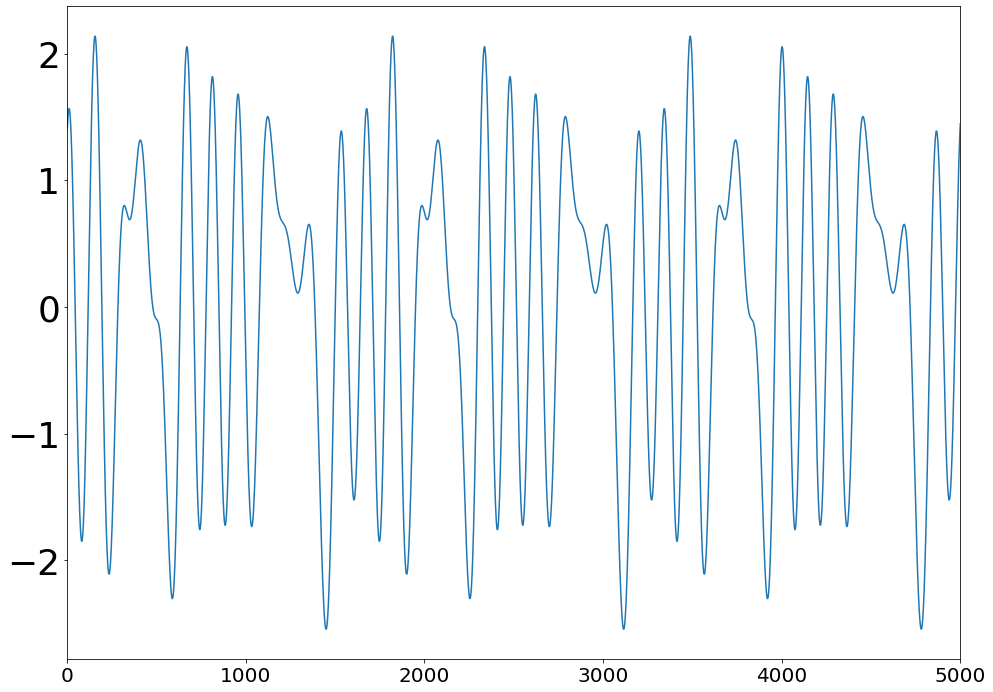

In [16]:
z_sig_10,tps_s,as_s = mock_injection_noise(2e8,lambda_val=10,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF")
plt.plot(z_sig_10)
plt.xlim(0,5000)

# make lists
alpha_scale_in = np.geomspace(5e7,5e9,20)
lambda_val_in = 20*[10]
direction_in = 20*["pull"]
phase_shift_in = 20*["TF"]

In [26]:
run_no =np.arange(0,100,1)
np.random.shuffle(run_no)


for i in tqdm(range(100)):
    print(i, run_no[i])
    z_trans_amp,TF_phase_shift,amplitude_scale = mock_injection_noise(alpha_scale=alpha_scale_in[i],lambda_val=lambda_val_in[i],height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift=phase_shift_in[i])
    file_creator_rounding_uniform_random_noise(in_file_paths,out_dir,direction=direction_in[i],run_no=run_no[i],max_file=1000)
    metafile_creator(i)
np.save(out_dir+"run_no.npy",run_no)
np.save(out_dir+"alpha_scale_in.npy",alpha_scale_in)
np.save(out_dir+"lambda_val_in.npy",lambda_val_in)
np.save(out_dir+"direction_in.npy",direction_in)
np.save(out_dir+"phase_shift_in.npy",phase_shift_in)




  0%|          | 0/100 [00:00<?, ?it/s]

0 43
Loading Gravity Data... Done!
68 2.04837466632e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  1%|          | 1/100 [01:52<3:05:46, 112.59s/it]

Done
1 17
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  2%|▏         | 2/100 [03:28<2:55:29, 107.44s/it]

Done
2 54
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  3%|▎         | 3/100 [04:53<2:43:06, 100.89s/it]

Done
3 44
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  4%|▍         | 4/100 [06:13<2:31:20, 94.59s/it] 

Done
4 64
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  5%|▌         | 5/100 [07:32<2:22:24, 89.94s/it]

Done
5 81
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  6%|▌         | 6/100 [08:52<2:16:07, 86.89s/it]

Done
6 13
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  7%|▋         | 7/100 [10:11<2:10:55, 84.47s/it]

Done
7 57
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  8%|▊         | 8/100 [11:30<2:07:18, 83.02s/it]

Done
8 58
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




  9%|▉         | 9/100 [12:51<2:04:37, 82.17s/it]

Done
9 84
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 10%|█         | 10/100 [14:11<2:02:21, 81.58s/it]

Done
10 61
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 11%|█         | 11/100 [16:08<2:17:04, 92.41s/it]

Done
11 53
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 12%|█▏        | 12/100 [17:50<2:19:27, 95.08s/it]

Done
12 24
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 13%|█▎        | 13/100 [19:40<2:24:23, 99.58s/it]

Done
13 79
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 14%|█▍        | 14/100 [21:29<2:26:46, 102.40s/it]

Done
14 6
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 15%|█▌        | 15/100 [23:55<2:43:50, 115.66s/it]

Done
15 9
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 16%|█▌        | 16/100 [25:30<2:33:16, 109.48s/it]

Done
16 62
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 17%|█▋        | 17/100 [27:02<2:24:12, 104.25s/it]

Done
17 12
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 18%|█▊        | 18/100 [28:23<2:12:56, 97.27s/it] 

Done
18 99
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 19%|█▉        | 19/100 [29:43<2:04:08, 91.96s/it]

Done
19 23
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 20%|██        | 20/100 [31:02<1:57:37, 88.21s/it]

Done
20 69
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 21%|██        | 21/100 [32:23<1:52:58, 85.80s/it]

Done
21 49
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 22%|██▏       | 22/100 [33:43<1:49:32, 84.27s/it]

Done
22 63
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 23%|██▎       | 23/100 [35:04<1:46:41, 83.14s/it]

Done
23 47
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 24%|██▍       | 24/100 [36:54<1:55:35, 91.26s/it]

Done
24 65
Loading Gravity Data... Done!
61 3.05657389272e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 25%|██▌       | 25/100 [38:53<2:04:17, 99.43s/it]

Done
25 30
Loading Gravity Data... Done!
61 3.05657389272e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 26%|██▌       | 26/100 [40:44<2:07:12, 103.14s/it]

Done
26 87
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 27%|██▋       | 27/100 [42:21<2:03:14, 101.30s/it]

Done
27 20
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 28%|██▊       | 28/100 [43:45<1:55:14, 96.03s/it] 

Done
28 72
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 29%|██▉       | 29/100 [45:07<1:48:34, 91.75s/it]

Done
29 16
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 30%|███       | 30/100 [46:28<1:43:25, 88.65s/it]

Done
30 89
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 31%|███       | 31/100 [47:55<1:41:17, 88.08s/it]

Done
31 96
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 32%|███▏      | 32/100 [49:39<1:45:17, 92.90s/it]

Done
32 19
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 33%|███▎      | 33/100 [51:33<1:50:44, 99.18s/it]

Done
33 10
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 34%|███▍      | 34/100 [53:16<1:50:14, 100.22s/it]

Done
34 0
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 35%|███▌      | 35/100 [55:22<1:56:55, 107.93s/it]

Done
35 27
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 36%|███▌      | 36/100 [57:05<1:53:46, 106.66s/it]

Done
36 90
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 37%|███▋      | 37/100 [58:27<1:44:00, 99.05s/it] 

Done
37 4
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 38%|███▊      | 38/100 [59:54<1:38:36, 95.43s/it]

Done
38 7
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 39%|███▉      | 39/100 [1:01:31<1:37:35, 95.99s/it]

Done
39 51
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 40%|████      | 40/100 [1:03:07<1:36:01, 96.03s/it]

Done
40 76
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 41%|████      | 41/100 [1:04:43<1:34:28, 96.08s/it]

Done
41 8
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 42%|████▏     | 42/100 [1:06:15<1:31:43, 94.88s/it]

Done
42 92
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 43%|████▎     | 43/100 [1:07:50<1:30:04, 94.82s/it]

Done
43 33
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 44%|████▍     | 44/100 [1:09:31<1:30:16, 96.72s/it]

Done
44 11
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 45%|████▌     | 45/100 [1:11:15<1:30:41, 98.94s/it]

Done
45 67
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 46%|████▌     | 46/100 [1:12:56<1:29:38, 99.61s/it]

Done
46 97
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 47%|████▋     | 47/100 [1:14:26<1:25:26, 96.73s/it]

Done
47 71
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]
Did not create /data/new_trap_processed/mockfiles/20200320/output/noise/Batch3/. It may exist or you do not have perimissions.




 48%|████▊     | 48/100 [1:15:52<1:20:55, 93.37s/it]

Done
48 82
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 49%|████▉     | 49/100 [1:17:18<1:17:34, 91.26s/it]

Done
49 91
Loading Gravity Data... Done!
61 3.05657389272e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 50%|█████     | 50/100 [1:18:43<1:14:21, 89.22s/it]

Done
50 25
Loading Gravity Data... Done!
61 3.05657389272e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 51%|█████     | 51/100 [1:20:14<1:13:24, 89.88s/it]

Done
51 48
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 52%|█████▏    | 52/100 [1:21:40<1:10:50, 88.55s/it]

Done
52 68
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 53%|█████▎    | 53/100 [1:23:17<1:11:23, 91.14s/it]

Done
53 41
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 54%|█████▍    | 54/100 [1:24:57<1:11:51, 93.72s/it]

Done
54 37
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 55%|█████▌    | 55/100 [1:26:40<1:12:35, 96.79s/it]

Done
55 35
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 56%|█████▌    | 56/100 [1:28:28<1:13:20, 100.02s/it]

Done
56 46
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 57%|█████▋    | 57/100 [1:30:10<1:12:04, 100.56s/it]

Done
57 85
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 58%|█████▊    | 58/100 [1:31:44<1:08:58, 98.53s/it] 

Done
58 59
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 59%|█████▉    | 59/100 [1:33:17<1:06:14, 96.93s/it]

Done
59 66
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 60%|██████    | 60/100 [1:34:50<1:03:52, 95.81s/it]

Done
60 77
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 61%|██████    | 61/100 [1:36:16<1:00:27, 93.00s/it]

Done
61 32
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 62%|██████▏   | 62/100 [1:37:40<57:07, 90.19s/it]  

Done
62 80
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 63%|██████▎   | 63/100 [1:39:32<59:41, 96.80s/it]

Done
63 52
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 64%|██████▍   | 64/100 [1:41:15<59:08, 98.58s/it]

Done
64 5
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 65%|██████▌   | 65/100 [1:42:58<58:20, 100.01s/it]

Done
65 3
Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 66%|██████▌   | 66/100 [1:44:22<53:48, 94.95s/it] 

Done
66 22
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 67%|██████▋   | 67/100 [1:45:48<50:51, 92.46s/it]

Done
67 94
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 68%|██████▊   | 68/100 [1:47:17<48:40, 91.26s/it]

Done
68 18
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 69%|██████▉   | 69/100 [1:48:44<46:30, 90.03s/it]

Done
69 50
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 70%|███████   | 70/100 [1:50:14<45:01, 90.05s/it]

Done
70 21
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 71%|███████   | 71/100 [1:51:45<43:39, 90.31s/it]

Done
71 34
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 72%|███████▏  | 72/100 [1:53:15<42:09, 90.32s/it]

Done
72 1
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 73%|███████▎  | 73/100 [1:55:10<43:57, 97.68s/it]

Done
73 28
Loading Gravity Data... Done!
93 4.9046048905e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 74%|███████▍  | 74/100 [1:56:57<43:34, 100.56s/it]

Done
74 86
Loading Gravity Data... Done!
61 3.05657389272e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 75%|███████▌  | 75/100 [1:58:19<39:31, 94.88s/it] 

Done
75 70
Loading Gravity Data... Done!
61 3.05657389272e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 76%|███████▌  | 76/100 [1:59:40<36:18, 90.77s/it]

Done
76 38
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.1630442426805148, 0.9994153484552486, 0.6126534653710891, 0.484330444815621, 0.289439346613426, 0.11311314277972492, 0.2697113172988871, 0.1335781872435983, 0.22970238284060143, 0.224309009095563, 0.24869285047651796, 0.23816595395001616, 0.0661052049608997]




 77%|███████▋  | 77/100 [2:01:01<33:41, 87.89s/it]

Done
77 42
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.2461547212562014, 0.9570431681159127, 0.6425185786926332, 0.4877838432534767, 0.31838256589624125, 0.10318071386150339, 0.2928182504700506, 0.1307126453382918, 0.2310568861990551, 0.23459744670423546, 0.2658833118443259, 0.26178629971634354, 0.07698725386275454]




 78%|███████▊  | 78/100 [2:02:24<31:36, 86.19s/it]

Done
78 98
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.2188857344790038, 0.9904825530583865, 0.7257895242217974, 0.4760758053251272, 0.29926620328695697, 0.12087946674873408, 0.2735632956159452, 0.12025285428464927, 0.242528634428027, 0.21635061663402264, 0.28965284677351394, 0.29928544262319995, 0.07032020013434409]




 79%|███████▉  | 79/100 [2:03:44<29:33, 84.44s/it]

Done
79 2
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.2408327551810265, 1.0218159480005224, 0.5977795724393861, 0.5058981648477964, 0.316660318622728, 0.12136735219602417, 0.30975401443960615, 0.13625107822474586, 0.22579852992317825, 0.22828905566341048, 0.2896211430117017, 0.26082895521826294, 0.07194798278692506]




 80%|████████  | 80/100 [2:05:06<27:52, 83.64s/it]

Done
80 55
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[ 2.3557498   2.09445151  2.00564173  1.60766578 -1.15041233 -2.82360391
 -3.10147047 -1.42043724  0.27490794 -1.39652202 -3.08064655  1.29097836
  0.33298596]




 81%|████████  | 81/100 [2:06:28<26:23, 83.36s/it]

Done
81 88
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-0.32929518  1.9062534   0.03243193 -2.02199471 -1.78414834  1.64508785
  2.44890911 -1.17840521  0.98512516  0.25129532  0.18332346 -0.18070422
  0.0045381 ]




 82%|████████▏ | 82/100 [2:07:50<24:49, 82.72s/it]

Done
82 45
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.04083711 -1.49184737  2.42144731  2.90547098 -2.99480249  3.01373432
  1.51764631  0.22727169 -3.0349606  -0.27202035 -1.00282038  2.84761171
 -1.1104596 ]




 83%|████████▎ | 83/100 [2:09:16<23:42, 83.69s/it]

Done
83 31
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[ 2.62341931  1.62507721  2.30606627  0.38902034  2.25252606 -0.5364442
 -1.44839939 -0.02411408 -2.71901556  2.7713104   2.07089075  0.88955093
 -1.98876486]




 84%|████████▍ | 84/100 [2:10:39<22:19, 83.70s/it]

Done
84 26
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.22, -0.97, -0.65, -0.49, -0.3, -0.12, -0.29, -0.13, -0.23, -0.22, -0.27, -0.27, -0.07]




 85%|████████▌ | 85/100 [2:12:03<20:55, 83.68s/it]

Done
85 15
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.22, -0.97, -0.65, -0.49, -0.3, -0.12, -0.29, -0.13, -0.23, -0.22, -0.27, -0.27, -0.07]




 86%|████████▌ | 86/100 [2:13:29<19:43, 84.53s/it]

Done
86 60
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.22, -0.97, -0.65, -0.49, -0.3, -0.12, -0.29, -0.13, -0.23, -0.22, -0.27, -0.27, -0.07]




 87%|████████▋ | 87/100 [2:14:53<18:14, 84.23s/it]

Done
87 78
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.22, -0.97, -0.65, -0.49, -0.3, -0.12, -0.29, -0.13, -0.23, -0.22, -0.27, -0.27, -0.07]




 88%|████████▊ | 88/100 [2:16:18<16:54, 84.57s/it]

Done
88 36
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.22, -0.97, -0.65, -0.49, -0.3, -0.12, -0.29, -0.13, -0.23, -0.22, -0.27, -0.27, -0.07]




 89%|████████▉ | 89/100 [2:17:52<16:01, 87.40s/it]

Done
89 93
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.22, -0.97, -0.65, -0.49, -0.3, -0.12, -0.29, -0.13, -0.23, -0.22, -0.27, -0.27, -0.07]




 90%|█████████ | 90/100 [2:19:25<14:48, 88.87s/it]

Done
90 40
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.22, -0.97, -0.65, -0.49, -0.3, -0.12, -0.29, -0.13, -0.23, -0.22, -0.27, -0.27, -0.07]




 91%|█████████ | 91/100 [2:20:48<13:04, 87.22s/it]

Done
91 75
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[-1.22, -0.97, -0.65, -0.49, -0.3, -0.12, -0.29, -0.13, -0.23, -0.22, -0.27, -0.27, -0.07]




 92%|█████████▏| 92/100 [2:22:13<11:32, 86.55s/it]

Done
92 14
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 93%|█████████▎| 93/100 [2:23:35<09:56, 85.18s/it]

Done
93 74
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 94%|█████████▍| 94/100 [2:25:17<09:01, 90.28s/it]

Done
94 29
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 95%|█████████▌| 95/100 [2:26:42<07:22, 88.57s/it]

Done
95 83
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 96%|█████████▌| 96/100 [2:28:07<05:49, 87.47s/it]

Done
96 39
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 97%|█████████▋| 97/100 [2:29:32<04:20, 86.80s/it]

Done
97 95
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 98%|█████████▊| 98/100 [2:31:03<02:56, 88.11s/it]

Done
98 73
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




 99%|█████████▉| 99/100 [2:32:28<01:27, 87.18s/it]

Done
99 56
Loading Gravity Data... Done!
77 1.2243891237e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]




100%|██████████| 100/100 [2:33:56<00:00, 87.40s/it]

Done


In [19]:
alpha_scale_in

[200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0,
 200000000.0]

In [8]:
no= 20
# make lists
alpha_scale_in = [np.random.randint(2,3)*1e8 for x in range(no)]
lambda_val_in = [20]*no
direction_in = no*["pull"]
phase_shift_in = no*["TF"]


In [18]:
run_no =np.arange(0,100,1)
#np.random.shuffle(run_no)


for i in tqdm(range(1)):
    print(i, run_no[i])
    z_trans_amp,TF_phase_shift,amplitude_scale = mock_injection_noise(alpha_scale=alpha_scale_in[i],lambda_val=lambda_val_in[i],height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift=phase_shift_in[i])
    file_creator_rounding_uniform_random_noise(in_file_paths,out_dir,direction=direction_in[i],run_no=run_no[i],max_file=1000)
    metafile_creator(i)
np.save(out_dir+"run_no.npy",run_no)
np.save(out_dir+"alpha_scale_in.npy",alpha_scale_in)
np.save(out_dir+"lambda_val_in.npy",lambda_val_in)
np.save(out_dir+"direction_in.npy",direction_in)
np.save(out_dir+"phase_shift_in.npy",phase_shift_in)


  0%|          | 0/1 [00:00<?, ?it/s]

0 0
Loading Gravity Data... Done!
68 2.04837466632e-05
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]


100%|██████████| 1/1 [02:15<00:00, 135.64s/it]

Done
